## Практическое задание

Вариант 1. (простой)

- обучить сверточную нейронную сеть в стиле AlexNet (с падением размера ядра свертки и последовательностью блоков свертка-пулинг  (conv-pool)-(conv-pool)-...) на датасете fashion-mnist или cifar10
- оценить рост точности при увеличении ширины сети (больше ядер)
- оценить рост точности при увеличении глубины сети (больше слоев)
- (опциционально)сравнить с точностью полносвязной сети для этой выборки
    </li>
</ol>

In [2]:
import numpy as np
import keras
from keras.datasets import fashion_mnist  # наборы для работы
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPool2D
from tensorflow.keras.utils import to_categorical

(x_train, y_train),(x_test, y_test)=fashion_mnist.load_data()


4431872/4422102 [==============================] - 0s 0us/step


In [3]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

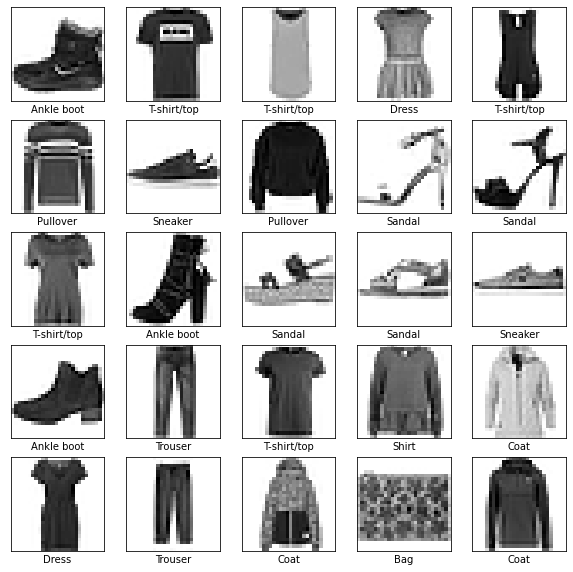

In [4]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])
plt.show()

In [5]:
num_classes = 10

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

# Normalize to float between 0 and 1
# Original pixel values are between 0 and 255
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255
x_test = x_test / 255

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print(x_train.shape[0], 'тренировочные примеры')
print(x_test.shape[0], 'тестовые примеры')

x_train shape: (60000, 28, 28, 1)
x_test shape: (10000, 28, 28, 1)
60000 тренировочные примеры
10000 тестовые примеры


In [6]:
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)
print(y_train)

[[0. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [7]:
x_train.shape

(60000, 28, 28, 1)

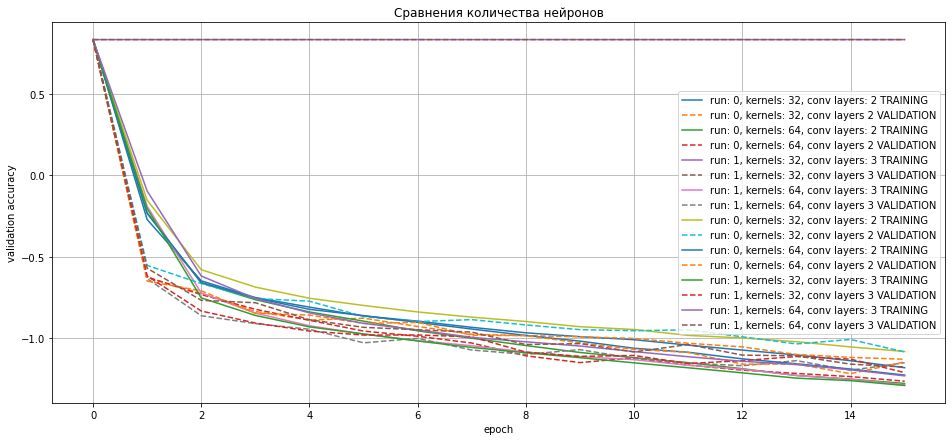

{'run: 0, 32 kernels, 2 conv layers': 0.88, 'run: 0, 64 kernels, 2 conv layers': 0.89, 'run: 1, 32 kernels, 3 conv layers': 0.89, 'run: 1, 64 kernels, 3 conv layers': 0.89}


In [85]:
accuracy_di = {}

plt.figure(figsize=(16,7))

layer_list = [1, 2]
kernel_list = [32, 64]
# число рабочих эпох
epochs = 15
# вектор для вывода результатов
epoch = np.arange(epochs+1)

# будем изменять количество нейронов
for i in range(2):
  for layers in layer_list:
    for kernel in kernel_list:
      # создаем рабочую модель model_neuron
      model_neuron = Sequential()
      model_neuron.add(Conv2D(kernel, (3,3), padding="same", activation="relu", input_shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3])))
      for i in range(layers):
        model_neuron.add(Conv2D(kernel, (3,3), padding="same", activation="relu"))
        model_neuron.add(MaxPool2D((3,3),padding="same"))
      model_neuron.add(Flatten())
      model_neuron.add(Dense(512, activation='relu'))
      model_neuron.add(Dropout(0.25))
      model_neuron.add(Dense(num_classes, activation='softmax'))
      
      # компилируем modeli с одним из оптимизаторов
      model_neuron.compile(
          optimizer='adam',
          loss='categorical_crossentropy',
          metrics=['accuracy'],
          )
      
      #model_neuron.summary()

      # вычисляем ошибку для modeli без обучения
      hh0_tr = model_neuron.evaluate(x_train[:48000,:], y_train[:48000],verbose = 0)
      hh0_val = model_neuron.evaluate(x_train[48000:,:], y_train[48000:],verbose = 0)
      # проводим обучение модели 
      hh = model_neuron.fit(x_train, y_train, epochs=epochs,
                    batch_size=32, validation_split=0.2, verbose = 0
                    )
      # картинки  
      #units = str(model_neuron.get_config()['layers'][-3]['config']['units'])

      plt.plot(epoch,np.log([hh0_tr[0]]+hh.history['loss']),'-',label ='run: '+str(i)+', kernels: '+str(kernel)+ ', conv layers: ' +str(layers+1)+' TRAINING')
      plt.plot(epoch,np.log([hh0_val[0]]+hh.history['val_loss']),'--',label ='run: '+str(i)+', kernels: '+str(kernel)+', conv layers '+str(layers+1)+' VALIDATION')

      max_acc = np.argmax(hh.history['val_accuracy'])
      accuracy_di['run: '+str(i)+', '+str(kernel)+' kernels, '+str(layers+1)+' conv layers'] = np.round(hh.history['val_accuracy'][max_acc],2)
  
plt.legend()
plt.grid('On')

plt.title('Сравнения количества нейронов')
plt.xlabel('epoch')
plt.ylabel('validation accuracy')
plt.show()

print(accuracy_di)

In [86]:
model_neuron.save_weights('model_neuron.h5')

In [87]:
model_neuron.evaluate(x_train[:48000],y_train[:48000])

1500/1500 [==============================] - 7s 5ms/step - loss: 0.2636 - accuracy: 0.9009


[0.26362940669059753, 0.9008958339691162]

Посмотрим на результаты предсказаний для обученной модели

In [90]:
import pandas as pd
pd.DataFrame.from_dict(accuracy_di, orient="index", columns=["accuracy"])['accuracy'].sort_values(ascending=False)

run: 1, 64 kernels, 3 conv layers    0.89
run: 1, 32 kernels, 3 conv layers    0.89
run: 0, 64 kernels, 2 conv layers    0.89
run: 0, 32 kernels, 2 conv layers    0.88
Name: accuracy, dtype: float64

Точность нейронной сети приблизительно одинаковая после ее насыщения ~90% 